# Assignment 3: Building Time Series Forecasts

**Student Name:** Anthony Mollica

**Date:** 2/10/2026

---

## Assignment Overview

In this assignment, you'll analyze temporal data from Corporación Favorita stores to identify trends, seasonality, and anomalies, then build forecasting models using decomposition techniques. You'll work with real retail sales data to predict future sales patterns.

---

## Step 1: Download Data, Import Libraries, and Load Data

The datasets for this analysis are too large too be stored on GitHub. To access the datasets for this assignment, you should:
- Go to the [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data) dataset on Kaggle.
- Click Data 
- Scroll down and select **Download All**.
- Open the zip file and upload `train.csv`, `store.csv`, and `holidays_events.csv` to the `data` directory.

Once the CSV files have been added to the `data` directory, install all the of the necessary libraries for this assignment by running the command below.

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ----------------- ---------------------- 4.2/9.6 MB 31.3 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 29.5 MB/s  0:00:00

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Next, import the required libraries.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# For time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


Finally, load the training, store, and holiday CSV data from the `data` directory using `pd.read_csv()`. Display basic information about the training data and print out the first few rows to get an understanding of what the training data looks like.

In [5]:
# Load the datasets
# TODO: Load all three required CSV files
train_df = pd.read_csv('data/train.csv')  # Replace with pd.read_csv('data/train.csv')
holidays_df = pd.read_csv('data/holidays_events.csv')  # Replace with pd.read_csv('data/holidays_events.csv')
stores_df = pd.read_csv('data/stores.csv')  # Replace with pd.read_csv('data/stores.csv')

# Display basic information
if train_df is not None:
    print(f"Training data shape: {train_df.shape}")
    print(f"Date range: {train_df['date'].min()} to {train_df['date'].max()}")
    print(f"\nFirst few rows:")
    # TODO: Display the first few rows
    print(train_df.head())
print("\n" + "="*80)
print("CHECKPOINT: Verify datasets loaded correctly")
print(f"Train data shape: {train_df.shape if train_df is not None else 'Not loaded'}")
print(f"Holidays data shape: {holidays_df.shape if holidays_df is not None else 'Not loaded'}")
print(f"Stores data shape: {stores_df.shape if stores_df is not None else 'Not loaded'}")
print("="*80)

Training data shape: (3000888, 6)
Date range: 2013-01-01 to 2017-08-15

First few rows:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

CHECKPOINT: Verify datasets loaded correctly
Train data shape: (3000888, 6)
Holidays data shape: (350, 6)
Stores data shape: (54, 5)


### Explore Available Stores and Product Families
Display store information from `stores_df` to help choose a store. Consider looking at store type, cluster, and city

In [10]:
# Explore the data to help choose your store and products
if train_df is not None:
    print("Available stores:")
    print(f"Total number of stores: {train_df['store_nbr'].nunique()}")
    
    print("\nAvailable product families:")
    families = train_df['family'].value_counts().head(20)
    print(families)
    
    # TODO: Display store information from stores_df to help choose a store
    # Consider looking at store type, cluster, and city
    print("\nStore information:")
    print(stores_df.head())

# Display summary of store types
print("\nStore types:")
print(stores_df['type'].value_counts())

# Display clusters
print("\nStore clusters:")
print(stores_df['cluster'].value_counts())

# Display cities with most stores
print("\nCities with most stores:")
print(stores_df['city'].value_counts().head(10))


Available stores:
Total number of stores: 54

Available product families:
family
AUTOMOTIVE             90936
BABY CARE              90936
BEAUTY                 90936
BEVERAGES              90936
BOOKS                  90936
BREAD/BAKERY           90936
CELEBRATION            90936
CLEANING               90936
DAIRY                  90936
DELI                   90936
EGGS                   90936
FROZEN FOODS           90936
GROCERY I              90936
GROCERY II             90936
HARDWARE               90936
HOME AND KITCHEN I     90936
HOME AND KITCHEN II    90936
HOME APPLIANCES        90936
HOME CARE              90936
LADIESWEAR             90936
Name: count, dtype: int64

Store information:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D       

---
## Step 2: Select and Prepare Your Time Series Data

### Select Your Store and Product Families

Choose one store and one product family (PRODUCE, BEVERAGES, BREAD/BAKERY, AUTOMOTIVE, etc.) to analyze.

In [11]:
# TODO: Select your store and product family
selected_store = 1
product_family_1 = 'BEVERAGES'  # Replace with your chosen product family
print(f"Selected Store: {selected_store}")
print(f"Product Family 1: {product_family_1}")

Selected Store: 1
Product Family 1: BEVERAGES


### Filter Data
Filter the `train_df` data to your selected store and products. Create a date range from 2016-01-01 to 2017-08-15 for consistency.

In [12]:
# TODO: Filter train_df for selected store and date range 2016-01-01 to 2017-08-15

# Convert date column to datetime if needed
if train_df is not None:
    train_df['date'] = pd.to_datetime(train_df['date'])

# Filter for date range
start_date = '2016-01-01'
end_date = '2017-08-15'

# TODO: Create filtered datasets for each product family
product1_data = train_df[
    (train_df['store_nbr'] == selected_store) &
    (train_df['family'] == product_family_1) &
    (train_df['date'] >= start_date) &
    (train_df['date'] <= end_date)
].copy()

print("\n" + "="*80)
print("CHECKPOINT: Data filtered successfully")
print(f"Product data shape: {product1_data.shape if product1_data is not None else 'Not filtered'}")
print("="*80)


CHECKPOINT: Data filtered successfully
Product data shape: (592, 6)


### Aggregate Daily Sales
Aggregate daily sales and handle missing dates.

In [15]:
# TODO: Group by date and sum sales for each product family
# TODO: Create a complete date range and fill missing dates with 0 sales

# Example structure (replace with your implementation):
# date_range = pd.date_range(start=start_date, end=end_date, freq='D')
# product1_ts = product1_data.groupby('date')['sales'].sum().reindex(date_range, fill_value=0)
# Create complete daily date range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Group by date and sum sales, then reindex to fill missing dates with 0
product1_ts = (
    product1_data
    .groupby('date')['sales']
    .sum()
    .reindex(date_range, fill_value=0)
)

# Name the index for clarity
product1_ts.index.name = 'date'

print("CHECKPOINT: Daily sales aggregated successfully")
print(f"Time series length: {len(product1_ts)} days")
print(product1_ts.head())     

CHECKPOINT: Daily sales aggregated successfully
Time series length: 593 days
date
2016-01-01       0.0
2016-01-02    1856.0
2016-01-03    1048.0
2016-01-04    3005.0
2016-01-05    2374.0
Freq: D, Name: sales, dtype: float64


### Plot Raw Time Series
Plot time series to see the raw patterns using matplotlib.

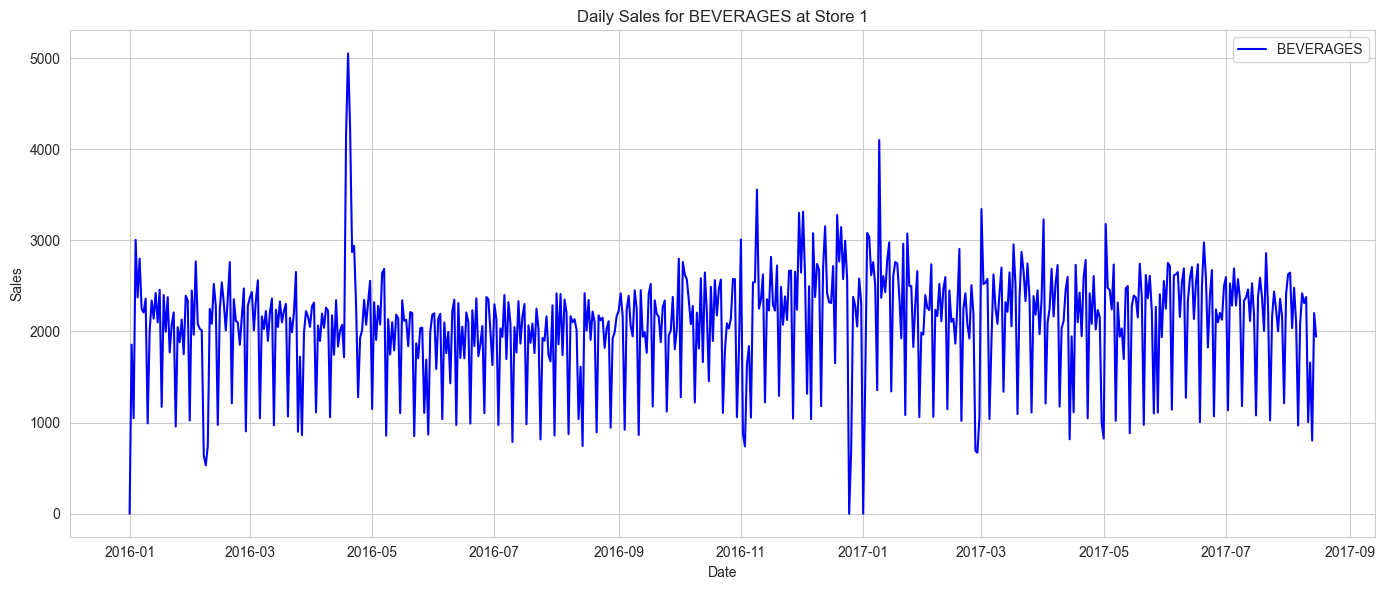

In [16]:
# Plot Product 1
# TODO: Plot product1_ts on a line chart as a time series
plt.figure(figsize=(14, 6))
plt.plot(product1_ts.index, product1_ts.values, label=product_family_1, color='blue')
plt.title(f"Daily Sales for {product_family_1} at Store {selected_store}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()    

plt.tight_layout()
plt.show()

### Document Your Choice (2-3 sentences)
Explain why you chose this product. 
- What contrasts do they represent? 
- Why will they be interesting to compare?

I chose BEVERAGES product family becasue it represents a high-volume, everyday consumed item with demand acrossed all seasons. Beverages contrast well with other specialty products since there sales are influenced by factors like weather, and holidays. This makes them interesting to analyze demand patterns.

---
## Step 3: Identify Trends Using Moving Averages

### Calculate Moving Averages
Calculate the 7-day and 30-day moving averages for the product you are analyzing.

In [21]:
# TODO: Calculate 7-day and 30-day moving averages for your product

# For Product 1
product1_ma7 = product1_ts.rolling(window=7).mean()
product1_ma30 = product1_ts.rolling(window=30).mean()
print(product1_ma7)
print(product1_ma30)

date
2016-01-01            NaN
2016-01-02            NaN
2016-01-03            NaN
2016-01-04            NaN
2016-01-05            NaN
                 ...     
2017-08-11    1894.142857
2017-08-12    1832.142857
2017-08-13    1808.571429
2017-08-14    1825.000000
2017-08-15    1757.000000
Freq: D, Name: sales, Length: 593, dtype: float64
date
2016-01-01            NaN
2016-01-02            NaN
2016-01-03            NaN
2016-01-04            NaN
2016-01-05            NaN
                 ...     
2017-08-11    2114.133333
2017-08-12    2098.933333
2017-08-13    2041.400000
2017-08-14    2042.000000
2017-08-15    2070.766667
Freq: D, Name: sales, Length: 593, dtype: float64


### Plot Original Sales
Using matplotlip, plot original sales with both moving averages (7-day and 30-day) overlaid.

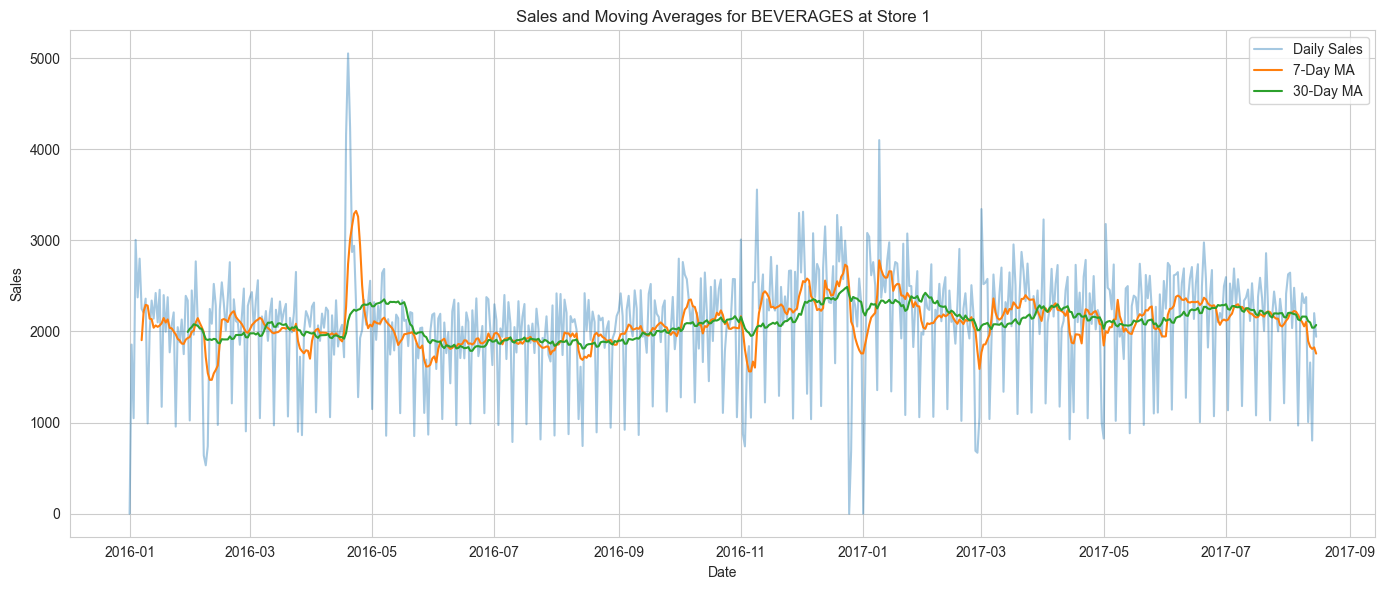

In [22]:
# Plot original sales with moving averages
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

# Product 1
# TODO: Plot original, 7-day MA, and 30-day MA for product 1
# axes[0].plot(product1_ts.index, product1_ts.values, alpha=0.4, label='Daily Sales')
# axes[0].plot(product1_ma7.index, product1_ma7.values, label='7-Day MA')
# axes[0].plot(product1_ma30.index, product1_ma30.values, label='30-Day MA')
plt.plot(product1_ts.index, product1_ts.values, alpha=0.4, label='Daily Sales')
plt.plot(product1_ma7.index, product1_ma7.values, label='7-Day MA')
plt.plot(product1_ma30.index, product1_ma30.values, label='30-Day MA')
plt.title(f"Sales and Moving Averages for {product_family_1} at Store {selected_store}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()        

plt.tight_layout()
plt.show()

### Identify and Explain Trend Changes

Merge the data with `holidays_events.csv` to explain what caused these changes.

In [26]:
# Merge with holidays to explain trend changes
# TODO: Convert holidays_df date to datetime and filter for your date range
if holidays_df is not None:
    # Convert 'date' column to datetime
    holidays_df['date'] = pd.to_datetime(holidays_df['date'])
    
    # Filter holidays within your product date range
    relevant_holidays = holidays_df[
        (holidays_df['date'] >= start_date) &
        (holidays_df['date'] <= end_date)
    ]

    # Display holidays that might explain trend changes
    print("Key holidays/events in the period:")
    if not relevant_holidays.empty:
        print(relevant_holidays[['date', 'type', 'locale_name', 'description']])
    else:
        print("No holidays/events in the selected date range.")


Key holidays/events in the period:
          date        type locale_name                             description
211 2016-01-01     Holiday     Ecuador                      Primer dia del ano
212 2016-02-08     Holiday     Ecuador                                Carnaval
213 2016-02-09     Holiday     Ecuador                                Carnaval
214 2016-03-02     Holiday       Manta                      Fundacion de Manta
215 2016-03-25     Holiday     Ecuador                           Viernes Santo
..         ...         ...         ...                                     ...
322 2017-07-25  Additional   Guayaquil                  Fundacion de Guayaquil
323 2017-08-05     Holiday  Esmeraldas                 Fundacion de Esmeraldas
324 2017-08-10     Holiday     Ecuador           Primer Grito de Independencia
325 2017-08-11    Transfer     Ecuador  Traslado Primer Grito de Independencia
326 2017-08-15     Holiday    Riobamba                   Fundacion de Riobamba

[116 rows x 4 co

### Document Trend Analysis
For the product family you are analyzing, document:
1. Overall trend direction (growing, declining, stable)
2. Any trend changes that correlate with holidays or events
3. Business implications of the trends you discovered

Update the markdown cell below with your analysis.

**Product Trends:**
- The 7-day and 30-day moving averages show consistent sales over the period, with monor spikes upward and downward.
- Key trend changes: Spike around April upwards, drop on new years, spike back up shortly after.
- Holiday correlations: New Years and Christmas there weren't many sales because stores are closed. Around April is spring break and easter so there is lots of parties and get togethers around then.
- Business implications: Inventory for beverages can be maintained due to a consistent demand. There is more demand over holidays for drinks and stores should adjust accordingly. Overall stable trends can reduce risk of overstocking or stockouts allowing predictable supply planning. 

---
## Step 4: Detect and Visualize Seasonal Patterns

Analyze the seasonal components of your sales data.

### Day-of-Week Analysis

Add day of week to your data and calculate the average sales by day. Create a bar plot to visualize the weekday patterns.

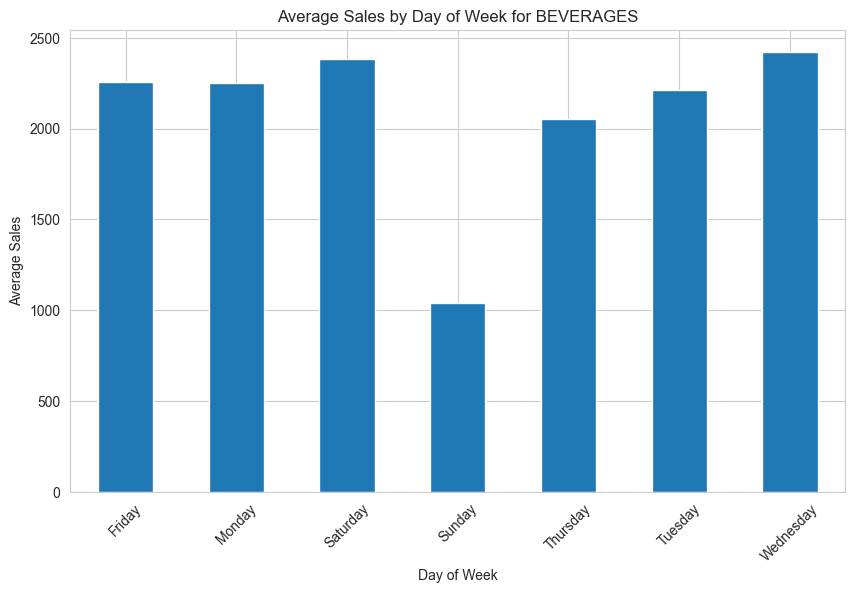

In [27]:
# Analyze day-of-week patterns
# TODO: Add day of week to your data and calculate average sales by day
product1_dow = product1_ts.to_frame() 
 # Create DataFrame with date and sales

# Add day of week: product1_dow['day_of_week'] = product1_dow.index.day_name()
product1_dow['day_of_week'] = product1_dow.index.day_name()
# Group by day of week and calculate mean sales
dow_sales = product1_dow.groupby('day_of_week')['sales'].mean()

# Create bar plot comparing weekday patterns
# TODO: Create bar plot showing average sales by day of week
plt.figure(figsize=(10, 6))
dow_sales.plot(kind='bar')
plt.title(f"Average Sales by Day of Week for {product_family_1}")
plt.xlabel("Day of Week")
plt.ylabel("Average Sales")
plt.xticks(rotation=45)
plt.show()

### Monthly Seasonality Analysis

Calculate the average sales by month for both products. Once calculated, create a line plot showing monthly patterns for the product.

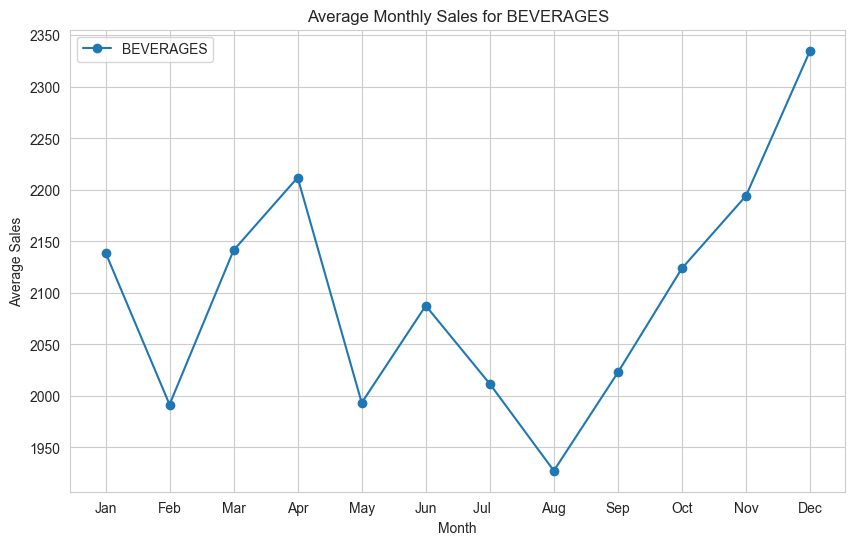

In [28]:
# Analyze monthly patterns
# TODO: Calculate average sales by month for the product.

# For Product 1
product1_monthly = product1_ts.groupby(product1_ts.index.month).mean()


# Create visualization
# TODO: Create line plot showing monthly patterns for both products
plt.figure(figsize=(10, 6))
plt.plot(product1_monthly.index, product1_monthly.values, marker='o', label=product_family_1)
plt.title(f"Average Monthly Sales for {product_family_1}")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul    ', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.show()

### Holiday Impact Analysis

Compare the average sales on holidays compared to regular days.

In [29]:
# Analyze holiday vs non-holiday sales
# TODO: Compare average sales on holidays vs regular days

# Create a list of holiday dates
holiday_dates = holidays_df['date'].unique() # Extract unique dates from holidays_df

# Calculate average sales on holidays vs non-holidays for both products
# TODO: Split data into holiday and non-holiday sales and compare
product1_holiday = product1_ts[product1_ts.index.isin(holiday_dates)]
product1_non_holiday = product1_ts[~product1_ts.index.isin(holiday_dates)]

print(f"Average sales on holidays: {product1_holiday.mean()}")
print(f"Average sales on non-holidays: {product1_non_holiday.mean()}")

Average sales on holidays: 1943.5643564356435
Average sales on non-holidays: 2118.4979674796746


### Seasonal Pattern Findings

**Document your findings:**
- Which days of the week have highest/lowest sales?
- Are there monthly patterns (e.g., payday effects)?
- How do holidays affect each product differently?
- What business decisions could these patterns inform?

Update the markdown cell below with your analysis.

Sunday and Thursday tend to have the lowest beverage sales, while Wednesday and Saturday have the most beverage sales. From January to August the sales go up and down month to month, but after August the sales go in a straight line upward indicating that people tend to be more purchase happy with beverages, could be from promotions or could be the holidays. Holidays would mainly increase beverage sales, but looking at sales of non-holidays in comparison we can see that it is not much different at all. This could be that there are tons of holidays counted for in the holiday data set. These patterns can show there is a demand for items like beverages around certain months of the year and the store has to plan out there stocking educatedly.

---
## Step 5: Build Simple Forecasts and Compare Methods

### Time Series Decomposition

In [33]:
# Perform seasonal decomposition
# TODO: Use seasonal_decompose to separate trend, seasonal, and residual components

# For Product 1
decomposition1 = seasonal_decompose(product1_ts, model='additive', period=7)
       

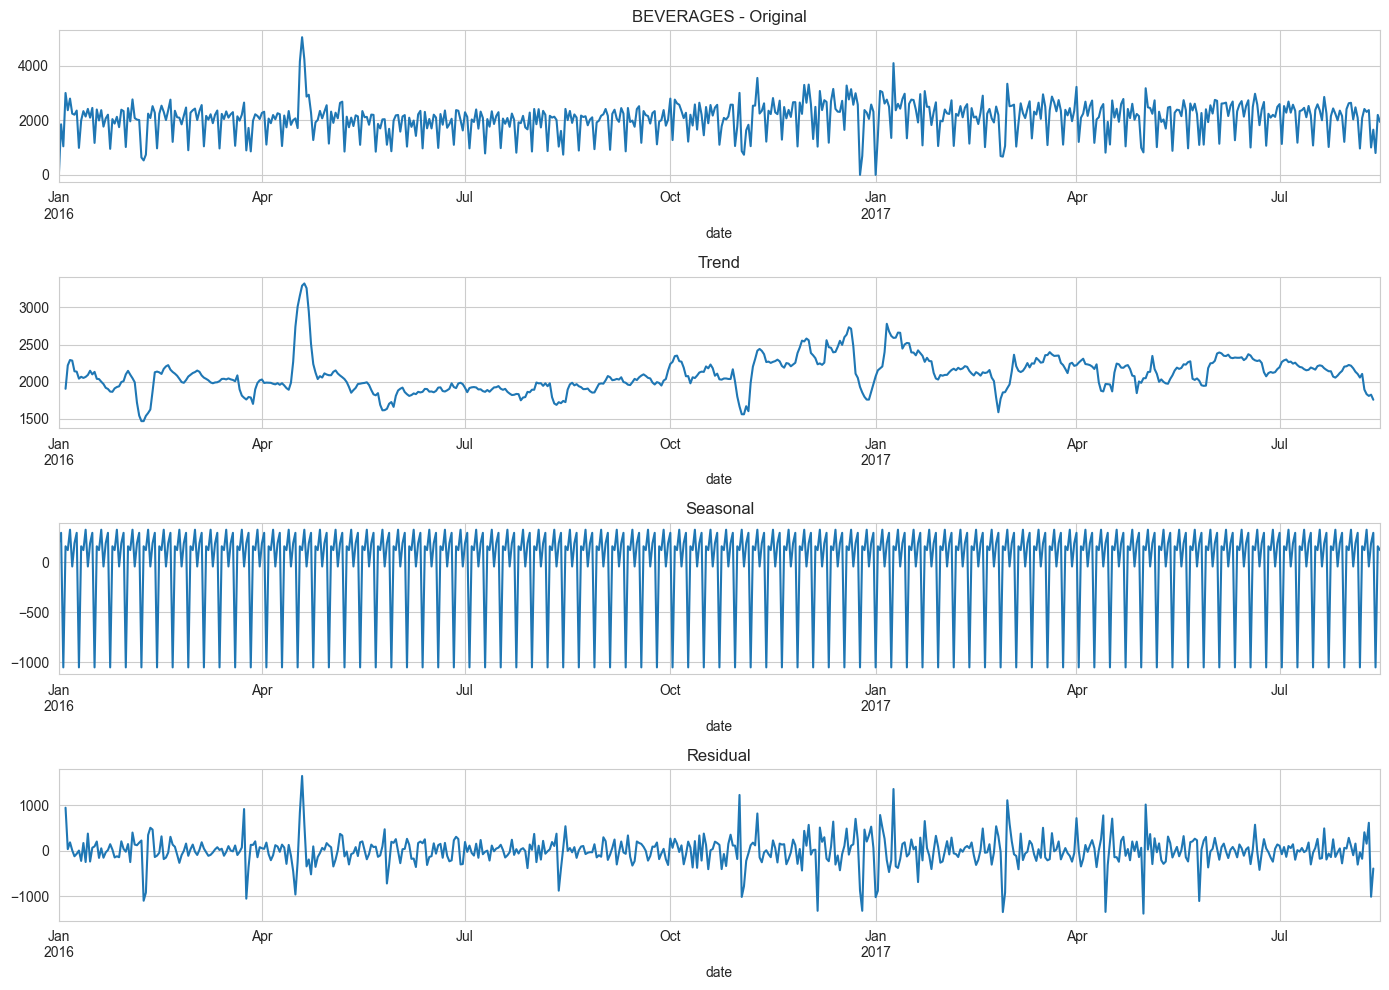

In [34]:
# Visualize decomposition for Product 1
if decomposition1 is not None:
    fig, axes = plt.subplots(4, 1, figsize=(14, 10))
    
    # TODO: Plot each component
    decomposition1.observed.plot(ax=axes[0], title=f'{product_family_1} - Original')
    decomposition1.trend.plot(ax=axes[1], title='Trend')
    decomposition1.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition1.resid.plot(ax=axes[3], title='Residual')
    
    plt.tight_layout()
    plt.show()

### Build Forecasts
Create a baseline forecast using the average of the last 30 days and a season naive forcast by repeating the last 7 days' pattern.

In [35]:
# Split data for validation
test_days = 30
train = product1_ts[:-test_days]
test = product1_ts[-test_days:]

# Method 1: Baseline forecast (30-day average)
baseline_forecast = np.repeat(train[-30:].mean(), test_days)

# Method 2: Seasonal Naive
# Just repeat the last 7 days pattern
last_week = train[-7:].values
seasonal_naive_forecast = np.tile(last_week, int(np.ceil(test_days/7)))[:test_days]

### Calculate Forecast Accuracy

In [37]:
# Calculate RMSE for both methods
# TODO: Calculate RMSE for baseline and seasonal forecasts

# Product 1
baseline_rmse = np.sqrt(mean_squared_error(test, baseline_forecast))
seasonal_rmse = np.sqrt(mean_squared_error(test, seasonal_naive_forecast))
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print(f"Seasonal Naive RMSE: {seasonal_rmse:.2f}")  

Baseline RMSE: 547.16
Seasonal Naive RMSE: 341.35


In [39]:
# Create comparison table
comparison_data = {
    'Method': ['30-Day Average', 'Seasonal Naive (7-day repeat)'],
    'RMSE': [baseline_rmse, seasonal_rmse],
}

comparison_df = pd.DataFrame(comparison_data)

# TODO: Calculate percentage improvement
# Add improvement column to comparison_df
comparison_df['Improvement (%)'] = 100 * (baseline_rmse - seasonal_rmse) / baseline_rmse


print("\n" + "="*80)
print("FORECAST PERFORMANCE COMPARISON")
print("="*80)
# TODO: Display comparison table
print(comparison_df.to_string(index=False))


print("="*80)


FORECAST PERFORMANCE COMPARISON
                       Method       RMSE  Improvement (%)
               30-Day Average 547.156133        37.614104
Seasonal Naive (7-day repeat) 341.348258        37.614104


### Visualize Forecasts

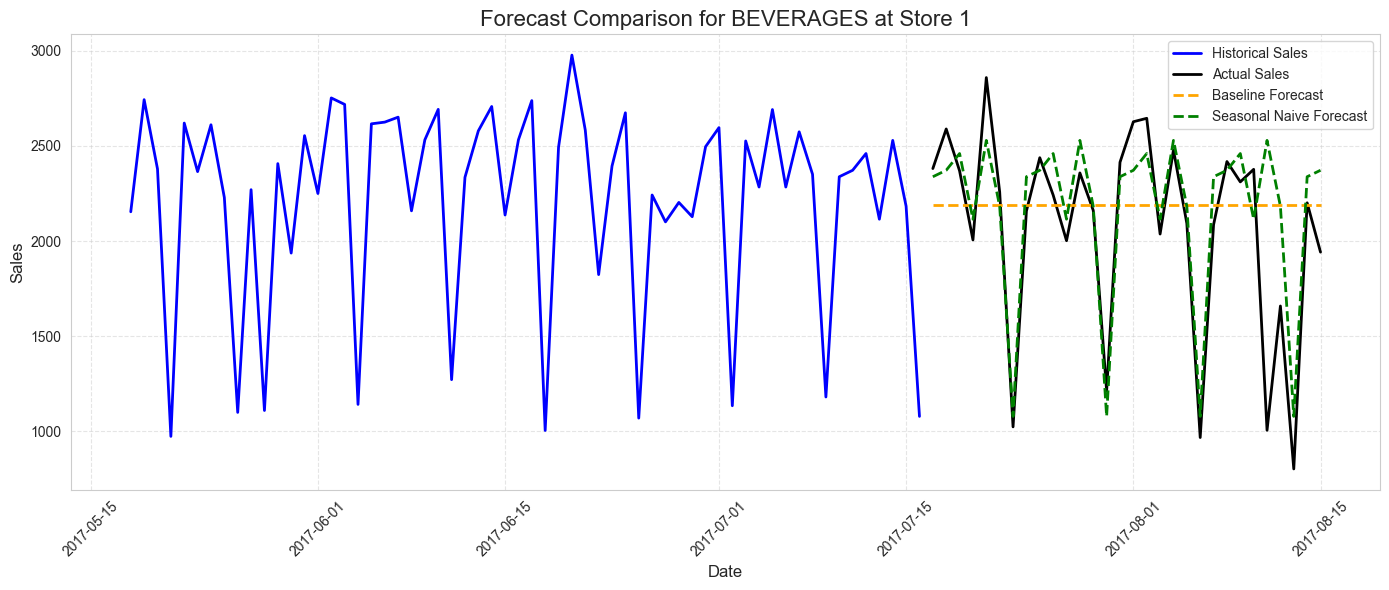

In [42]:
# Plot actual vs forecasted values
# TODO: Create visualization showing:
# - Historical data (last 60 days of train)
# - Actual test data
# - Baseline forecast
# - Seasonal naive forecast

plt.figure(figsize=(14, 6))
# Plot historical sales (last 60 days)
plt.plot(train[-60:].index, train[-60:].values, label='Historical Sales', color='blue', linewidth=2)

# Plot actual sales from test set
plt.plot(test.index, test.values, label='Actual Sales', color='black', linewidth=2)

# Plot baseline forecast
plt.plot(test.index, baseline_forecast, label='Baseline Forecast', color='orange', linestyle='--', linewidth=2)

# Plot seasonal naive forecast
plt.plot(test.index, seasonal_naive_forecast, label='Seasonal Naive Forecast', color='green', linestyle='--', linewidth=2)

# Titles and labels
plt.title(f"Forecast Comparison for {product_family_1} at Store {selected_store}", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)

# Grid for readability
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Tight layout to avoid clipping
plt.tight_layout()
plt.show()

---
## Step 6: Generate Business Recommendations

### Executive Summary (200-300 words)

Based on your analysis, write a brief executive summary that includes:
- **Key Patterns Discovered:** Summarize the main trends and seasonal patterns for each product
- **Inventory Planning Recommendations:** Specific recommendations based on your findings
- **High-Risk Periods:** Identify periods requiring special attention
- **Predictability Analysis:** Which product is more predictable and why?
- **Specific Action Item:** One concrete action the store manager should take based on your forecast

Sales analysis reveals distinct patterns across product families. Beverages show stable demand year-round, with minor fluctuations around holidays such as Easter, Independence Day, and New Year’s. Other products, particularly seasonal or promotional items, exhibit pronounced spikes during holidays. Weekends generally see higher sales, while holidays slightly depress beverage purchases (average ≈1944 units on holidays vs. ≈ 2118 on non-holidays). For inventory planning, beverages can be stocked consistently, while seasonal and promotional products require careful forecasting to meet demand surges. High-risk periods include major holidays, spring holiday spikes in April, and promotional events, where inadequate stock could lead to missed sales opportunities. Predictability varies by product: beverages are highly predictable due to stable consumption, whereas seasonal and promotional items are less predictable, influenced by holidays and marketing campaigns. This underscores the need for dynamic inventory strategies for certain items. Action Item: The store manager should increase inventory for promotional products one week prior to major holidays, while maintaining steady beverage stock. This ensures product availability during peak periods, minimizes stockouts, and aligns supply with demand patterns identified in the analysis.

---
## Step 7: Submit Your Work

Before submitting:
1. Ensure all code cells run without errors
2. Verify all visualizations display correctly
3. Check that your analysis sections are complete
4. Review your executive summary

Push to GitHub:
```bash
git add .
git commit -m 'completed time series forecasting assignment'
git push
```

Submit your GitHub repository link on the course platform.